In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ROC and PR for Unbalanced Datasets

Practice problems from Bill@Deloitte.

Tasks:
0. Set up an unbalanced dataset
1. Plot an ROC Curve
2. Plot precision as a function of TPR (aka PR curve)
3. Given priors, find operating point.
4. Confirm that PR depends on tested priors, but ROC does not

## 1. Set up an unbalanced dataset

In [2]:
# method to create the unbalanced dataset
def make_unbalanced_blobs(pos_prob):
    from sklearn.datasets import make_blobs

    X, y = make_blobs(n_samples=20000, cluster_std=5, centers=2, random_state=123)

    temp = []
    for i in range(len(X)):
        if y[i]==0 and np.random.uniform()>pos_prob:
            temp.append([X[i][0], X[i][1], y[i]])
        elif y[i]==1 and np.random.uniform()<=pos_prob:
            temp.append([X[i][0], X[i][1], y[i]])

    X = np.array([[t[0], t[1]] for t in temp])
    y = np.array([t[2] for t in temp])
    return X, y

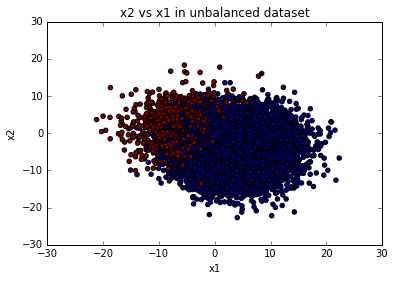

In [3]:
# generate an unbalanced dataset with 10% positive
pos_prob = 0.10
X, y = make_unbalanced_blobs(pos_prob)

# view a sample dataset
x1 = [i[0] for i in X]
x2 = [i[1] for i in X]

plt.scatter(x1, x2, c=y)
plt.title("x2 vs x1 in unbalanced dataset")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

There is a little bit of overlap in our dummy data, which will give the classifier a little trouble. This is good, or else we will have a perfect classifier and thus a very boring ROC curve.

We will now split our dataset into training and testing sets.

In [4]:
# split train and test datasets
train_proportion = 0.75
train_size = int(len(X)*train_proportion)
X_train = X[train_size:]
y_train = y[train_size:]
X_test = X[:train_size]
y_test = y[:train_size]

With the data split we now train the model on the training subset.

In [5]:
# import classifier and build model on first 7500 samples
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now that we have build the model on the training set, let's see what at what probability the model predicts for each of the test set records.

In [6]:
# predict class for last 2500 samples
y_pred_proba = classifier.predict_proba(X_test)

Below are the probabilities for the first 5 test set records. In each element the first number is the probability that y==0 and the second is probability that y==1. Notice each element adds to 1.

In [7]:
print y_pred_proba[:5]

[[  9.74163443e-01   2.58365571e-02]
 [  9.99845054e-01   1.54946101e-04]
 [  3.94181729e-02   9.60581827e-01]
 [  9.95638109e-01   4.36189096e-03]
 [  7.97155331e-01   2.02844669e-01]]


Let's move on to the exercises.

## 2. Plot an ROC Curve

An ROC curve is the plot of the FPR vs TPR of a classifier as the discrimation threshold is increased for 0% to 100%.

To plot an ROC curve we first have to obtain results from a classification problem. For this practice set we will generate some dummy data then classify using a logistic regression.

In [8]:
# function to calculate build ROC curve
def plot_ROC(y_pred_proba, y_actual, steps=100, debug=False):
    # convert y_actual
    y_actual = np.array(y_actual)
    # instantiate fpr and tpr arrays
    fpr = []
    tpr = []
    # step through descrimation threshold from 0-1 by step_size
    for thresh in np.linspace(0, 1, num=steps, endpoint=False):
        # assign True if probability >= threshold, else False
        y_pred = np.array([proba>=thresh for proba in y_pred_proba])
        # calculate tp, fp, fn, and tn counts
        tp = ((y_pred==True) & (y_actual==True)).sum()
        fp = ((y_pred==True) & (y_actual==False)).sum()
        fn = ((y_pred==False) & (y_actual==True)).sum()
        tn = ((y_pred==False) & (y_actual==False)).sum()
        # calculate and append tpr and fpr
        if (tp+fn) > 0 and (fp+tn) > 0:
            tpr.append(float(tp)/(tp+fn))
            fpr.append(float(fp)/(fp+tn))
        if debug==True:
            print "{:.2}\t{:.2}\t{:.2}".format(thresh, tpr[-1], fpr[-1])
    # plot ROC curve
    plt.plot(fpr, tpr, 'b-')
    plt.title("ROC Curve")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

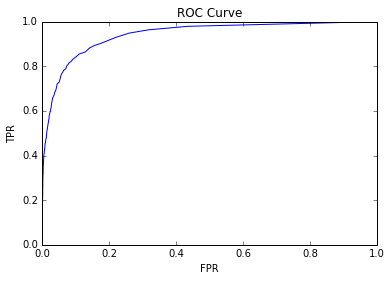

In [9]:
y1_pred_proba = [p[1] for p in y_pred_proba]
y1_test = [True if y==1 else False for y in y_test]

plot_ROC(y1_pred_proba, y1_test)

## 3. Plot Precision as a function of TPR (aka PR curve)

In [10]:
# function to calculate build prec vs tpr curve (aka PR curve)
def plot_PR(y_pred_proba, y_actual, steps=100, debug=False):
    # convert y_actual
    y_actual = np.array(y_actual)
    # instantiate precision and recall arrays
    prec = []
    rec = []
    # step through descrimation threshold from 0-1 by step_size
    for thresh in np.linspace(0, 1, num=steps, endpoint=False):
        # assign True if probability >= threshold, else False
        y_pred = np.array([proba>=thresh for proba in y_pred_proba])
        # calculate tp, fp, fn, and tn counts
        tp = ((y_pred==True) & (y_actual==True)).sum()
        fp = ((y_pred==True) & (y_actual==False)).sum()
        fn = ((y_pred==False) & (y_actual==True)).sum()
        tn = ((y_pred==False) & (y_actual==False)).sum()
        # calculate and append tpr and fpr
        if (tp+fp) > 0 and (tp+fn) > 0:
            prec.append(float(tp)/(tp+fp))
            rec.append(float(tp)/(tp+fn))
        if debug==True:
            print "{:.2}\t{:.2}\t{:.2}".format(thresh, prec[-1], rec[-1])
    # plot ROC curve
    plt.plot(rec, prec, 'b-')
    plt.title("PR Curve")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

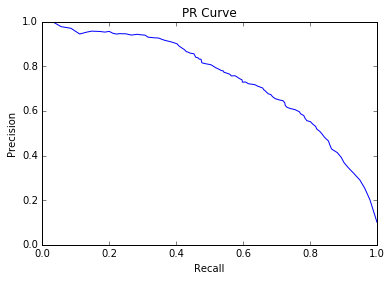

In [11]:
y1_pred_proba = [p[1] for p in y_pred_proba]
y1_test = [True if y==1 else False for y in y_test]

plot_PR(y1_pred_proba, y1_test)

# 4. Given priors, find operating point of a classifier

If we knew the prior probabilities of a true event, how would this influence the operating point (aka discrimination threshold) of our classifier?

Let's run through a common example: we want our classifier to catch a some disease but this disease occurs in 1% of the population we're looking at.

This means that to achieve a Precision of greater than 1%(?).

We can generate an example dataset given this information:

Prior = (actual true)/(dataset) = (TP+FN)/(TP+FP+FN+TN)

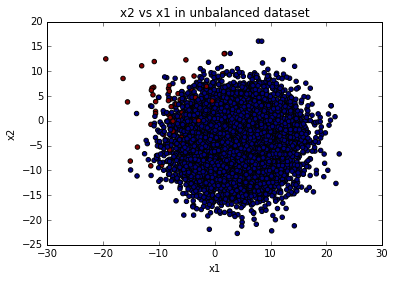

In [12]:
# generate an unbalanced dataset with 1% positive
pos_prob = 0.01
X, y = make_unbalanced_blobs(pos_prob)

# view a sample dataset
x1 = [i[0] for i in X]
x2 = [i[1] for i in X]

plt.scatter(x1, x2, c=y)
plt.title("x2 vs x1 in unbalanced dataset")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## 5. Confirm that PR depends on tested priors, but ROC does not

Let's offload some tasks to the sklearn library.

In [13]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve

# run through an increasing array of probabilities
pos_probs = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

fpr = {}
tpr = {}
prec = {}
rec = {}

# build classifier and get ROC and PR metrics for classifier
for prob in pos_probs:
    X, y = make_unbalanced_blobs(prob)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y1_pred_proba = [p[1] for p in clf.predict_proba(X_test)]

    fpr[str(prob)], tpr[str(prob)], thresholds = roc_curve(y_test, y1_pred_proba)
    prec[str(prob)], rec[str(prob)], thresholds = precision_recall_curve(y_test, y1_pred_proba)

# Plot a ROC curve over this array of priors
for p in [str(i) for i in pos_probs]:
    plt.plot(fpr[p], tpr[p], label=p)

plt.show()

# Plot a PR curve over this same array of priors
for p in [str(i) for i in pos_probs]:
    plt.plot(rec[p], prec[p], label=p)

plt.show()

As we can see above, the ROC curve basically remains the same while the PR curve fluctates wildly.

Since ROC is FPR vs TPR and PR is TPF vs Precision, we can say that this comes down to the difference between FPR and Precision. This makes sense since FPR looks at FP whereas Prei